# Libraries

In [127]:
import  pandas as pd
import  numpy as np
import  pickle
import  json
import  plotly.express as px
import  matplotlib.pyplot as plt
import  plotly.graph_objs as go
from    sklearn.impute          import SimpleImputer
from    imblearn.over_sampling  import SMOTE
from    sklearn.preprocessing   import StandardScaler
from    sklearn.ensemble        import RandomForestClassifier
from    sklearn.model_selection import RandomizedSearchCV
from    sklearn.model_selection import cross_validate
from    sklearn.metrics         import make_scorer
from    sklearn.metrics         import accuracy_score
from    sklearn.metrics         import confusion_matrix
from    sklearn.metrics         import precision_score
from    sklearn.metrics         import recall_score
from    sklearn.metrics         import f1_score
from    sklearn.metrics         import roc_auc_score
from    sklearn.metrics         import ConfusionMatrixDisplay
from    sklearn.metrics         import RocCurveDisplay
from    xgboost                 import XGBClassifier
from    sklearn.decomposition   import PCA

In [2]:
RANDOM_SEED = np.random.seed(0)

In [3]:
cd ..\

c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction


c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Train

In [4]:
df_train = pd.read_csv('data\\original\\air_system_previous_years.csv',
                       encoding='utf-8',
                       na_values=['na']
                      )
df_train.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [5]:
df_train.dtypes

class      object
aa_000      int64
ab_000    float64
ac_000    float64
ad_000    float64
           ...   
ee_007    float64
ee_008    float64
ee_009    float64
ef_000    float64
eg_000    float64
Length: 171, dtype: object

In [6]:
df_train.isna().sum().sort_values(ascending=False)

br_000    49264
bq_000    48722
bp_000    47740
bo_000    46333
ab_000    46329
          ...  
cj_000      338
ci_000      338
bt_000      167
aa_000        0
class         0
Length: 171, dtype: int64

In [7]:
df_train['class'].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

In [8]:
# Calculate events proportion
total     = df_train.shape[0]
non_event = df_train[df_train['class'] == 'neg'].shape[0]
event     = df_train[df_train['class'] == 'pos'].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

non_event_percent, event_percent

(98.33, 1.67)

In [9]:
# Calculate correlations
df_corr = df_train.drop(columns='class').corr()
df_corr

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,1.000000,0.073103,-0.032055,-0.001903,0.061971,0.089474,0.018610,0.143153,0.285815,0.495529,...,0.735324,0.739211,0.717810,0.727240,0.726984,0.606232,0.471707,0.248039,0.019865,0.037099
ab_000,0.073103,1.000000,-0.019411,0.047281,0.031031,0.053532,0.008418,0.013658,0.050068,0.068100,...,0.062280,0.098808,0.068790,0.078091,0.048717,0.023867,0.039369,0.074119,0.055590,0.162948
ac_000,-0.032055,-0.019411,1.000000,-0.002380,-0.004997,-0.010554,0.017620,-0.001088,-0.016665,-0.038680,...,-0.013692,-0.008111,-0.009849,-0.011206,-0.021430,-0.029417,0.016908,0.024354,-0.006571,0.014228
ad_000,-0.001903,0.047281,-0.002380,1.000000,-0.000214,-0.000269,-0.000047,-0.000131,-0.000222,-0.000423,...,-0.002090,-0.002047,-0.001940,-0.001667,-0.001398,-0.000829,-0.002161,-0.001050,-0.000102,-0.000120
ae_000,0.061971,0.031031,-0.004997,-0.000214,1.000000,0.823108,-0.000430,-0.000832,0.005057,0.034163,...,0.017338,0.024905,0.017311,0.039967,0.085884,0.052357,-0.010850,-0.008206,0.070886,0.041715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.606232,0.023867,-0.029417,-0.000829,0.052357,0.070306,0.000307,0.044186,0.182990,0.505565,...,0.454833,0.446803,0.437682,0.379892,0.545929,1.000000,0.224938,0.061478,-0.000715,0.002708
ee_008,0.471707,0.039369,0.016908,-0.002161,-0.010850,-0.013976,-0.000823,0.004878,0.009466,0.021151,...,0.453811,0.481392,0.459517,0.406920,0.373871,0.224938,1.000000,0.710056,-0.006991,-0.002833
ee_009,0.248039,0.074119,0.024354,-0.001050,-0.008206,-0.010237,-0.001230,-0.004309,-0.009498,-0.019311,...,0.228248,0.239302,0.224638,0.190667,0.163792,0.061478,0.710056,1.000000,-0.003942,-0.000907
ef_000,0.019865,0.055590,-0.006571,-0.000102,0.070886,0.106281,-0.000072,0.002875,0.011824,0.020560,...,0.007118,0.017480,0.005835,0.050270,0.008461,-0.000715,-0.006991,-0.003942,1.000000,0.282184


In [10]:
# Replace correlations greater than 0.7
df_low_corr = df_corr.copy()
for column in df_corr:
    for i, row in df_corr.iterrows():
        if row[column] > 0.7:
            df_low_corr.loc[i, column] = np.nan

In [11]:
df_low_corr

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
aa_000,NaN,0.073103,-0.032055,-0.001903,0.061971,0.089474,0.018610,0.143153,0.285815,0.495529,...,NaN,NaN,NaN,NaN,NaN,0.606232,0.471707,0.248039,0.019865,0.037099
ab_000,0.073103,NaN,-0.019411,0.047281,0.031031,0.053532,0.008418,0.013658,0.050068,0.068100,...,0.062280,0.098808,0.068790,0.078091,0.048717,0.023867,0.039369,0.074119,0.055590,0.162948
ac_000,-0.032055,-0.019411,NaN,-0.002380,-0.004997,-0.010554,0.017620,-0.001088,-0.016665,-0.038680,...,-0.013692,-0.008111,-0.009849,-0.011206,-0.021430,-0.029417,0.016908,0.024354,-0.006571,0.014228
ad_000,-0.001903,0.047281,-0.002380,NaN,-0.000214,-0.000269,-0.000047,-0.000131,-0.000222,-0.000423,...,-0.002090,-0.002047,-0.001940,-0.001667,-0.001398,-0.000829,-0.002161,-0.001050,-0.000102,-0.000120
ae_000,0.061971,0.031031,-0.004997,-0.000214,NaN,NaN,-0.000430,-0.000832,0.005057,0.034163,...,0.017338,0.024905,0.017311,0.039967,0.085884,0.052357,-0.010850,-0.008206,0.070886,0.041715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ee_007,0.606232,0.023867,-0.029417,-0.000829,0.052357,0.070306,0.000307,0.044186,0.182990,0.505565,...,0.454833,0.446803,0.437682,0.379892,0.545929,NaN,0.224938,0.061478,-0.000715,0.002708
ee_008,0.471707,0.039369,0.016908,-0.002161,-0.010850,-0.013976,-0.000823,0.004878,0.009466,0.021151,...,0.453811,0.481392,0.459517,0.406920,0.373871,0.224938,NaN,NaN,-0.006991,-0.002833
ee_009,0.248039,0.074119,0.024354,-0.001050,-0.008206,-0.010237,-0.001230,-0.004309,-0.009498,-0.019311,...,0.228248,0.239302,0.224638,0.190667,0.163792,0.061478,NaN,NaN,-0.003942,-0.000907
ef_000,0.019865,0.055590,-0.006571,-0.000102,0.070886,0.106281,-0.000072,0.002875,0.011824,0.020560,...,0.007118,0.017480,0.005835,0.050270,0.008461,-0.000715,-0.006991,-0.003942,NaN,0.282184


# Preprocessing

In [12]:
# Change class to int dummies
map_class = {'neg': 0, 'pos': 1}
df_train['class'] = df_train['class'].map(map_class)

# Features to float
features = df_train.drop(columns='class').columns
df_train[features] = df_train[features].astype(float)

## zscore for outliers

In [132]:
# Check for outliers
scaler_for_outliers = StandardScaler()
scaler_for_outliers.fit(df_train[features])
X_scaled = scaler_for_outliers.transform(df_train[features])
X_scaled = pd.DataFrame(X_scaled, columns=features)
X_scaled.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119381,NaN,2.232688,-0.004711,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.688022,0.519511,0.235649,0.067657,0.005703,-0.108976,-0.145729,-0.176720,-0.020733,-0.024093
1,-0.180697,NaN,-0.447891,NaN,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.020847,-0.060853,-0.130470,-0.132494,-0.186507,-0.153429,-0.091554,-0.145121,-0.020733,-0.024093
2,-0.125811,NaN,-0.447891,-0.004715,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.145485,-0.094447,-0.018610,0.013932,-0.011516,-0.108938,-0.097000,-0.165892,-0.020733,-0.024093
3,-0.407928,-0.205008,-0.447891,-0.004716,-0.042213,-0.004799,-0.010823,-0.02853,-0.057251,-0.115886,...,-0.385321,-0.388505,-0.381473,-0.351374,-0.311507,-0.200384,-0.308627,-0.176720,0.894847,3.599684
4,0.010572,NaN,-0.447889,-0.004707,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.152763,0.034351,-0.034611,-0.041710,-0.043122,-0.020087,0.656774,-0.151062,-0.020733,-0.024093


In [131]:
zscore_interval_95_percent = 1.645

# Replace outliers with NaN
remove_outliers = np.where((X_scaled > zscore_interval_95_percent) | (X_scaled < -zscore_interval_95_percent),
                            np.nan,
                            X_scaled
                          )
X_scaled_no_outliers = pd.DataFrame(remove_outliers,
                                    columns=X_scaled.columns,
                                    index=X_scaled.index
                                    )
X_scaled_no_outliers.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.119381,NaN,NaN,-0.004711,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.688022,0.519511,0.235649,0.067657,0.005703,-0.108976,-0.145729,-0.176720,-0.020733,-0.024093
1,-0.180697,NaN,-0.447891,NaN,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.020847,-0.060853,-0.130470,-0.132494,-0.186507,-0.153429,-0.091554,-0.145121,-0.020733,-0.024093
2,-0.125811,NaN,-0.447891,-0.004715,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,-0.145485,-0.094447,-0.018610,0.013932,-0.011516,-0.108938,-0.097000,-0.165892,-0.020733,-0.024093
3,-0.407928,-0.205008,-0.447891,-0.004716,-0.042213,-0.004799,-0.010823,-0.02853,-0.057251,-0.115886,...,-0.385321,-0.388505,-0.381473,-0.351374,-0.311507,-0.200384,-0.308627,-0.176720,0.894847,NaN
4,0.010572,NaN,-0.447889,-0.004707,-0.042213,-0.052466,-0.010823,-0.02853,-0.057251,-0.116304,...,0.152763,0.034351,-0.034611,-0.041710,-0.043122,-0.020087,0.656774,-0.151062,-0.020733,-0.024093


In [15]:
# Replace outliers with NaN on original train dataset
df_train_no_outliers = df_train.copy()
for column in X_scaled_no_outliers:
    for i, row in X_scaled_no_outliers.iterrows():
        if np.isnan(row[column]):
            df_train_no_outliers.loc[i, column] = np.nan

## Remove zero variance

In [16]:
# Find features with zero variance
for col in df_train_no_outliers.columns:
    std = df_train_no_outliers[col].std()
    if std == 0:
        col_to_drop = col
        print(col_to_drop, std)

ch_000 0.0


In [17]:
df_train_no_outliers.dropna(how='all', inplace=True, axis=1)
# Remove features with zero variance
features_no_outliers = df_train_no_outliers.drop(columns=['class', col_to_drop]).columns
features_no_outliers

Index(['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000',
       'ag_001', 'ag_002', 'ag_003',
       ...
       'ee_002', 'ee_003', 'ee_004', 'ee_005', 'ee_006', 'ee_007', 'ee_008',
       'ee_009', 'ef_000', 'eg_000'],
      dtype='object', length=168)

## Input data on NaN

In [18]:
# Use the median to replace NaN values
imputer = SimpleImputer(strategy='median')
imputer.fit(df_train_no_outliers[features_no_outliers])

# Save the imputer to a file
with open('train_artifacts\\simple_imputer.pkl', 'wb') as file:
    pickle.dump(imputer, file)

In [19]:
# Load the imputer from the file
with open('train_artifacts\\simple_imputer.pkl', 'rb') as file:
    imputer = pickle.load(file)

df_train_no_outliers[features_no_outliers] = imputer.transform(df_train_no_outliers[features_no_outliers])
df_train_no_outliers[features_no_outliers].isna().sum().sum()

np.int64(0)

## Balance data

In [20]:
# Balance train data minority class
X_train = df_train_no_outliers[features_no_outliers]
target  = 'class'
y_train = df_train_no_outliers[target]

oversample = SMOTE(sampling_strategy='minority', random_state=RANDOM_SEED)
oversample.fit(X_train, y_train)
# Save the oversample to a file
with open('train_artifacts\\oversample.pkl', 'wb') as file:
    pickle.dump(oversample, file)

In [21]:
# Load the oversample from the file
with open('train_artifacts\\oversample.pkl', 'rb') as file:
    oversample = pickle.load(file)

X_train_balanced, y_train_balanced = oversample.fit_resample(X_train, y_train)

In [22]:
df_train_balanced = X_train_balanced.join(y_train_balanced)
df_train_balanced.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000,class
0,76698.0,0.0,74.0,280.0,0.0,0.0,0.0,0.0,0.0,0.0,...,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0,0
1,33058.0,0.0,0.0,126.0,0.0,0.0,0.0,0.0,0.0,0.0,...,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0,0
2,41040.0,0.0,228.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0,0
3,12.0,0.0,70.0,66.0,0.0,10.0,0.0,0.0,0.0,318.0,...,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,0.0,0
4,60874.0,0.0,1368.0,458.0,0.0,0.0,0.0,0.0,0.0,0.0,...,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0,0


In [23]:
# Calculate events proportion
total     = df_train_balanced.shape[0]
non_event = df_train_balanced[df_train_balanced['class'] == 0].shape[0]
event     = df_train_balanced[df_train_balanced['class'] == 1].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

non_event_percent, event_percent

(50.0, 50.0)

## PCA

In [133]:
scaler = StandardScaler()
scaler.fit(X_train_balanced)
X_scaled_new = scaler.transform(X_train_balanced)
X_scaled_new = pd.DataFrame(X_scaled_new, columns=features)
X_scaled_new.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,0.521648,-0.23702,-0.158170,-0.114771,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,1.734574,1.351581,0.643109,0.298798,0.189814,-0.330158,-0.095821,-0.347014,-0.061429,-0.072045
1,-0.256471,-0.23702,-0.170193,-0.173285,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,0.025811,-0.072974,-0.248159,-0.238130,-0.335236,-0.461508,0.072420,-0.211223,-0.061429,-0.072045
2,-0.114149,-0.23702,-0.133149,-0.183164,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,-0.274633,-0.155433,0.024149,0.154673,0.142777,-0.330045,0.055507,-0.300483,-0.061429,-0.072045
3,-0.845694,-0.23702,-0.158820,-0.196083,-0.077082,0.654346,-0.132911,-0.305014,-0.294271,-0.311966,...,-0.852769,-0.877225,-0.859193,-0.825302,-0.676692,-0.600251,-0.601703,-0.347014,24.677896,-0.072045
4,0.239500,-0.23702,0.052073,-0.047138,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,0.444307,0.160714,-0.014804,0.005408,0.056440,-0.067507,2.396354,-0.236751,-0.061429,-0.072045


In [134]:
pca = PCA().fit(X_scaled_new)
X_train_reduced = pca.transform(X_scaled_new)
X_train_reduced = pd.DataFrame(X_train_reduced, columns=['PC_' + str(i + 1) for i in range(X_scaled_new.shape[1])])
X_train_reduced

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_159,PC_160,PC_161,PC_162,PC_163,PC_164,PC_165,PC_166,PC_167,PC_168
0,7.065271,-3.682664,-0.221918,4.351913,0.545955,2.156124,0.061874,-0.675740,0.001498,-1.060249,...,0.186179,-0.166214,-0.090467,-0.060018,-0.014713,0.013958,0.026346,-0.001704,-3.039252e-08,7.419603e-08
1,-0.320689,-1.128344,-0.661400,0.617053,0.094494,-0.364544,-0.327713,1.807581,0.159606,-0.329777,...,-0.379037,0.513266,-0.027086,0.049264,0.012249,-0.002167,0.000954,-0.002254,3.327402e-08,4.244141e-08
2,-1.872693,-2.741387,0.560519,0.828810,0.175468,-0.197006,-0.770947,-0.837496,-0.053423,-0.100968,...,-0.083475,0.094467,-0.008832,0.022146,-0.013032,-0.000331,0.000914,0.000217,9.154698e-08,6.503333e-09
3,-7.064954,-1.095163,1.314966,-2.136005,-0.013427,-1.306264,1.222964,1.159324,-0.366845,0.393269,...,0.124252,-0.134029,-0.062709,0.015169,-0.109865,-0.010606,-0.007753,-0.001596,1.843332e-07,8.909221e-08
4,2.400998,-2.982366,0.492312,2.157648,0.330537,1.962819,1.221820,-1.364870,0.095170,0.169099,...,-0.133334,0.162815,0.029619,-0.011659,0.002321,-0.014629,-0.001797,0.000842,1.901322e-07,7.830192e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117995,18.674748,-0.888093,-1.470938,-4.931742,0.135464,-2.012547,0.352216,0.970324,-2.522841,1.100371,...,-0.110915,-0.121511,0.067383,-0.116818,0.142323,0.018440,-0.002272,-0.001065,-3.204129e-07,-2.106374e-07
117996,4.857456,5.419095,-3.718879,-0.146918,4.662049,1.872631,-7.967071,-0.068580,18.466135,9.292619,...,0.407934,-0.057124,-0.267028,-0.099850,0.043856,-0.048629,-0.019646,-0.002312,-2.894032e-08,-1.310736e-07
117997,-2.265889,3.704925,-2.768602,-0.157527,-1.602760,3.028399,0.340885,0.619925,-0.504175,-1.311091,...,0.043390,-0.017017,-0.091239,0.080012,-0.132099,0.001362,0.005978,-0.002023,9.681242e-08,-6.470818e-09
117998,5.479543,2.937190,6.860787,-3.973802,-0.168514,-1.445875,0.542611,-0.905163,0.899306,-0.925528,...,-0.074194,-0.151821,-0.143677,0.039559,0.005665,-0.041544,0.032214,0.003178,-3.190318e-07,-4.473602e-08


In [27]:
df_pca_expl_var_ratio = pd.DataFrame(pca.explained_variance_ratio_, columns=['exp_var_ratio'])
df_pca_expl_var_ratio['cum_exp_var_ratio'] = df_pca_expl_var_ratio['exp_var_ratio'].cumsum()
df_pca_expl_var_ratio

,exp_var_ratio,cum_exp_var_ratio
0,1.928298e-01,0.192830
1,4.281060e-02,0.235640
2,2.874033e-02,0.264381
3,2.804741e-02,0.292428
4,2.449869e-02,0.316927
...,...,...
163,2.644058e-05,0.999970
164,2.521371e-05,0.999995
165,4.843994e-06,1.000000
166,2.003224e-13,1.000000


In [28]:
fig = px.line(df_pca_expl_var_ratio, x=df_pca_expl_var_ratio.index, y='cum_exp_var_ratio',)
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis = dict(title='Cumulative variance ratio'),
                  xaxis = dict(title='Components')
                  )
fig.show()

In [ ]:
# n_components_expl_var = df_pca_expl_var_ratio[df_pca_expl_var_ratio['cum_exp_var_ratio'] >= 0.8].index[0]
# n_components_expl_var

In [165]:
pca_new = PCA(0.9).fit(X_scaled_new)  # Define how much variance to explain
# # Save pca to a file
# with open('train_artifacts\\pca.pkl', 'wb') as file:
#     pickle.dump(pca_new, file)

In [ ]:
n_components_expl_var = pd.DataFrame(pca_new.components_).shape[0]
n_components_expl_var

In [ ]:
pd.DataFrame(pca_new.components_).shape[0]

In [164]:
cols_new = ['PC_' + str(i +1) for i in range(n_components_expl_var)]
X_train_reduced_new = pca_new.transform(X_scaled_new)
X_train_reduced_new = pd.DataFrame(X_train_reduced_new, columns=cols_new)
X_train_reduced_new

ValueError: Shape of passed values is (118000, 98), indices imply (118000, 68)

In [35]:
pca_components_corr = pd.DataFrame(X_train_reduced_new).corr()
fig = px.imshow(pca_components_corr, color_continuous_scale='Viridis_r')
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10)
                  )
fig.show()

In [32]:
df_pca_expl_var_ratio_new = pd.DataFrame(pca_new.explained_variance_ratio_, columns=['exp_var_ratio'])
df_pca_expl_var_ratio_new['cum_exp_var_ratio'] = df_pca_expl_var_ratio_new['exp_var_ratio'].cumsum()
df_pca_expl_var_ratio_new

,exp_var_ratio,cum_exp_var_ratio
0,0.192830,0.192830
1,0.042811,0.235640
2,0.028740,0.264381
3,0.028047,0.292428
4,0.024499,0.316927
...,...,...
63,0.004464,0.780468
64,0.004358,0.784826
65,0.004342,0.789168
66,0.004294,0.793463


In [33]:
fig = px.line(df_pca_expl_var_ratio_new, x=df_pca_expl_var_ratio_new.index, y='cum_exp_var_ratio',)
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                  yaxis = dict(title='Cumulative variance ratio'),
                  xaxis = dict(title='Components', dtick=5)
                  )
fig.show()

# Functions

In [160]:
def calculate_feature_importance(model):
    # Calculate feature importance (Gini)
    feat_importance    = model.feature_importances_
    df_feat_importance = pd.DataFrame({'feature'   : model.feature_names_in_,
                                       'importance': feat_importance}
                                      ).sort_values('importance', ascending=True)

    plt.figure(figsize=(8, 4))
    plt.boxplot(x=df_feat_importance['importance'], vert=False)
    plt.xlabel('Importance')
    plt.title('Feature importance distribution')

    df_feat_importance_non_zero = df_feat_importance[df_feat_importance['importance'] > 0]
    plt.figure(figsize=(8, 10))
    plt.barh(df_feat_importance_non_zero['feature'], df_feat_importance_non_zero['importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'{df_feat_importance_non_zero.shape[0]} importance greater than 0')

    return df_feat_importance, df_feat_importance_non_zero

In [44]:
def plot_cross_validation_score(cv_results, score):
    # Create a line plot
    plot_fig, plot_ax = plt.subplots(figsize=(8, 4))
    plot_ax.plot(cv_results[f'train_{score}'],
                 marker='o',
                 linestyle='-',
                 color='blue',
                 label='Train'
                )
    plot_ax.plot(cv_results[f'test_{score}'],
                 marker='o',
                 linestyle='-',
                 color='red',
                 label='Validation'
                )
    plot_ax.set_xlabel('Iteration')
    plot_ax.set_xticks(range(1, len(cv_results[f'train_{score}'])))
    plot_ax.set_ylabel('Score')
    plot_ax.set_title(f'Cross-validation {score} score')
    plot_ax.legend()
    plot_ax.grid(True)

# Model

## Random forest

In [38]:
def create_hyper_parameters_range_rand_forest(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=1
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=1
                                )
    range_min_samples_split = np.arange(start=round(parameters.get('model_parameters')['min_samples_split'][0], 2),
                                        stop=round(parameters.get('model_parameters')['min_samples_split'][-1], 2),
                                        step=0.1
                                        )
    range_min_samples_leaf = np.arange(start=round(parameters.get('model_parameters')['min_samples_leaf'][0], 2),
                                       stop=round(parameters.get('model_parameters')['min_samples_leaf'][-1], 2),
                                       step=1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'min_samples_split': range_min_samples_split,
                           'min_samples_leaf' : range_min_samples_leaf
                          }
    
    return param_distributions

In [39]:
parameters_rand_forest = {
    "model_parameters": {
        "n_estimators": [5, 100],
        "criterion": ["gini"],
        "max_depth": [3, 13],
        "min_samples_split": [0.2, 1],
        "min_samples_leaf": [1, 7]
    },
    "cross_validation": {
        "n_iterations": 10,
        "folders": 5,
        "scores": [
            "recall",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "rand_forest",
    "predict_method": "predict_proba"
}

In [40]:
param_dist_rand_forest = create_hyper_parameters_range_rand_forest(parameters_rand_forest)

In [41]:
rand_forest = RandomForestClassifier(random_state=RANDOM_SEED, verbose=0)

random_search_rand_forest = RandomizedSearchCV(estimator=rand_forest,
                                               param_distributions=param_dist_rand_forest,
                                               verbose=3,
                                               cv=parameters_rand_forest.get('cross_validation')['folders'],
                                               n_iter=parameters_rand_forest.get('cross_validation')['n_iterations'],
                                               random_state=RANDOM_SEED,
                                               scoring=make_scorer(roc_auc_score)
                                               )
random_search_rand_forest.fit(X_train_reduced_new, y_train_balanced)

best_params_rand_forest = random_search_rand_forest.best_params_
rand_forest_clf = RandomForestClassifier(**best_params_rand_forest, random_state=RANDOM_SEED)
rand_forest_clf.fit(X_train_reduced_new, y_train_balanced)
print(f'\nBest parameters:\n{best_params_rand_forest}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=9, min_samples_leaf=3, min_samples_split=0.5000000000000001, n_estimators=16;, score=0.892 total time=   1.7s
[CV 2/5] END max_depth=9, min_samples_leaf=3, min_samples_split=0.5000000000000001, n_estimators=16;, score=0.875 total time=   1.7s
[CV 3/5] END max_depth=9, min_samples_leaf=3, min_samples_split=0.5000000000000001, n_estimators=16;, score=0.896 total time=   1.5s
[CV 4/5] END max_depth=9, min_samples_leaf=3, min_samples_split=0.5000000000000001, n_estimators=16;, score=0.884 total time=   1.8s
[CV 5/5] END max_depth=9, min_samples_leaf=3, min_samples_split=0.5000000000000001, n_estimators=16;, score=0.793 total time=   1.5s
[CV 1/5] END max_depth=7, min_samples_leaf=2, min_samples_split=0.30000000000000004, n_estimators=65;, score=0.907 total time=  13.2s
[CV 2/5] END max_depth=7, min_samples_leaf=2, min_samples_split=0.30000000000000004, n_estimators=65;, score=0.903 total time=  13.6s
[CV 3/

c:\Users\victo\Downloads\00. Estudo Data Science\aps_failure_truck_prediction\venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning:

invalid value encountered in cast




Best parameters:
{'n_estimators': np.int64(80), 'min_samples_split': np.float64(0.30000000000000004), 'min_samples_leaf': np.int64(6), 'max_depth': np.int64(3)}


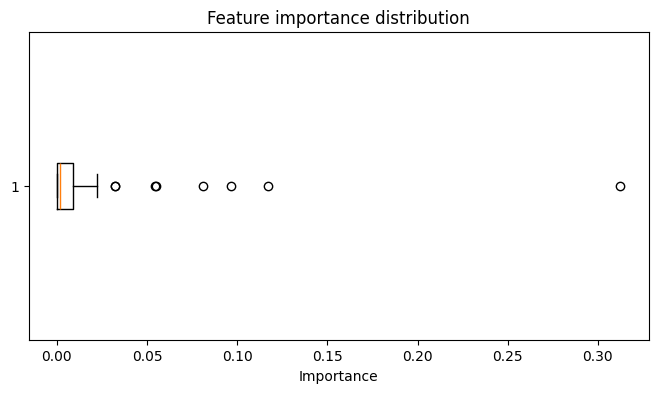

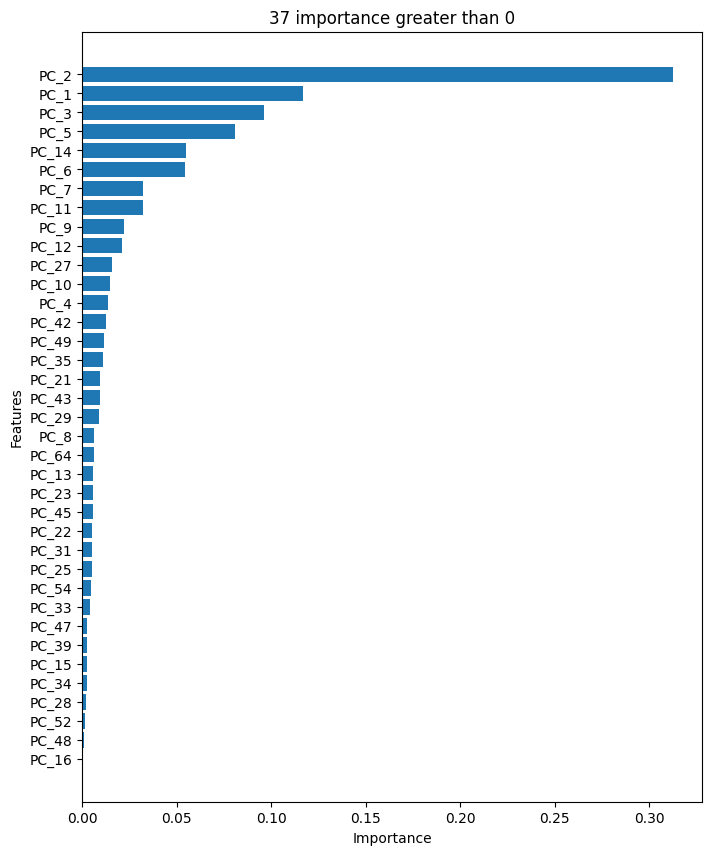

In [162]:
df_feat_importance_rand_forest, df_feat_importance_non_zero_rand_forest = calculate_feature_importance(rand_forest_clf)

### Cross-validation scores

>>>>>>>>> CV recall train mean: 0.9538
>>>>>>>>> CV recall test mean:  0.9538
>>>>>>>>> CV f1_macro train mean: 0.9022
>>>>>>>>> CV f1_macro test mean:  0.9019
>>>>>>>>> CV roc_auc train mean: 0.9615
>>>>>>>>> CV roc_auc test mean:  0.9613
>>>>>>>>> CV precision_macro train mean: 0.9068
>>>>>>>>> CV precision_macro test mean:  0.9066


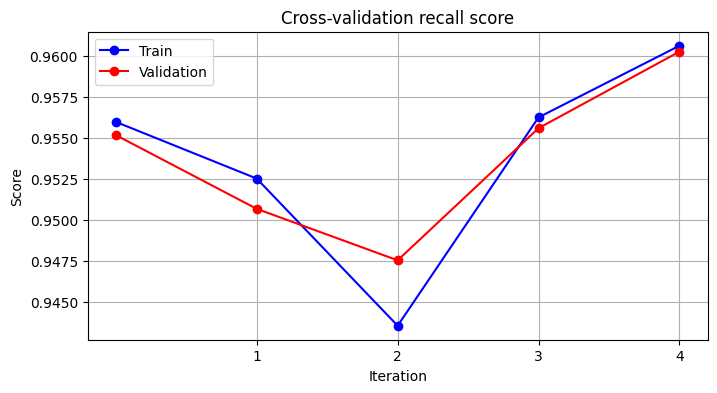

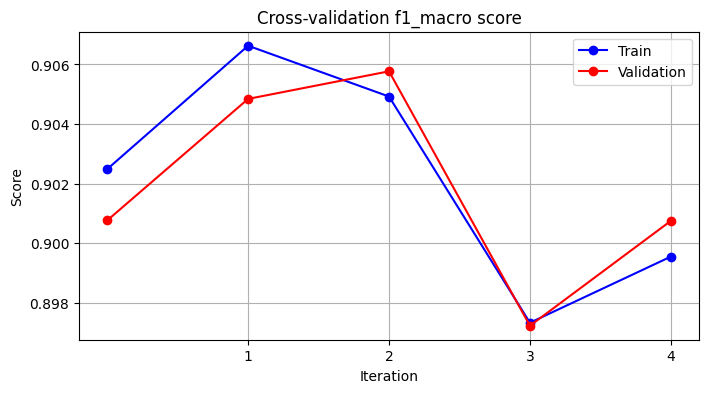

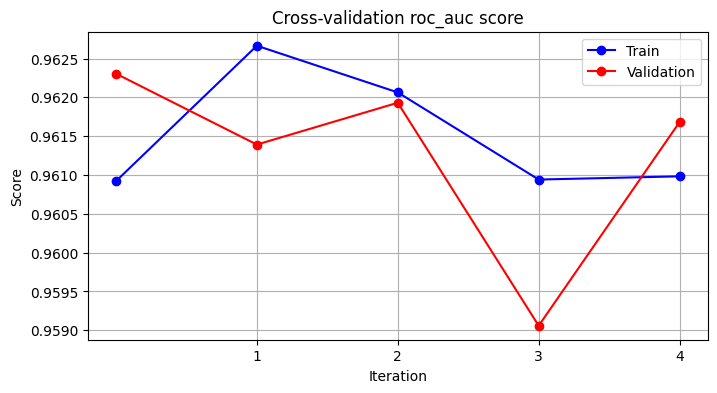

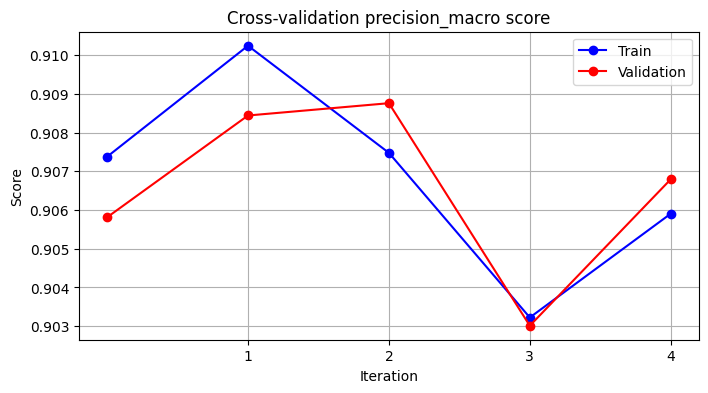

In [58]:
cv_results_rand_forest = cross_validate(estimator=rand_forest_clf,
                                        X=X_train_reduced_new,
                                        y=y_train_balanced,
                                        scoring=parameters_rand_forest.get('cross_validation')['scores'],
                                        cv=parameters_rand_forest.get('cross_validation')['folders'],
                                        verbose=0,
                                        return_train_score=True,
                                        error_score=np.nan
                                        )

# Calculate cross-validation scores
for score in parameters_rand_forest.get('cross_validation')['scores']:
    cv_train_mean = cv_results_rand_forest[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_rand_forest[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_rand_forest, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

## XGBoost

In [60]:
def create_hyper_parameters_range_xgb(parameters: dict):
    range_n_estimators = np.arange(start=round(parameters.get('model_parameters')['n_estimators'][0], 2),
                                   stop=round(parameters.get('model_parameters')['n_estimators'][-1], 2),
                                   step=1
                                   )
    range_max_depth = np.arange(start=round(parameters.get('model_parameters')['max_depth'][0], 2),
                                stop=round(parameters.get('model_parameters')['max_depth'][-1], 2),
                                step=1
                                )
    range_learning_rate = np.arange(start=round(parameters.get('model_parameters')['learning_rate'][0], 2),
                                    stop=round(parameters.get('model_parameters')['learning_rate'][-1], 2),
                                    step=0.01
                                    )
    range_subsample = np.arange(start=round(parameters.get('model_parameters')['subsample'][0], 2),
                                stop=round(parameters.get('model_parameters')['subsample'][-1], 2),
                                step=0.01
                                )
    range_colsample_bytree = np.arange(start=round(parameters.get('model_parameters')['colsample_bytree'][0], 2),
                                       stop=round(parameters.get('model_parameters')['colsample_bytree'][-1], 2),
                                       step=0.1
                                       )
    param_distributions = {'n_estimators'     : range_n_estimators,
                           'max_depth'        : range_max_depth,
                           'learning_rate'    : range_learning_rate,
                           'subsample'        : range_subsample,
                           'colsample_bytree' :range_colsample_bytree
                          }
    
    return param_distributions

In [61]:
parameters_xgb_clf = {
    "model_parameters": {
        "n_estimators": [50, 101],
        "max_depth": [2, 10],
        "learning_rate": [0.01, 0.1],
        "subsample": [0.05, 1],
        "colsample_bytree": [0.2, 1]
    },
    "cross_validation": {
        "n_iterations": 10,
        "folders": 5,
        "scores": [
            "accuracy",
            "f1_macro",
            "roc_auc",
            "precision_macro"
        ]
    },
    "maintenance_cost": {
        "no_defect_cost": 10,
        "preventive_cost": 25,
        "corrective_cost": 500
    },
    "target": "class",
    "cutoff": 0.3,
    "model_name": "xgb_clf",
    "predict_method": "predict_proba"
}

In [62]:
param_dist_xgb_clf = create_hyper_parameters_range_xgb(parameters_xgb_clf)

In [63]:
xgb_clf = XGBClassifier(random_state=RANDOM_SEED, verbosity=0)

random_search_xgb_clf = RandomizedSearchCV(estimator=xgb_clf,
                                           param_distributions=param_dist_xgb_clf,
                                           verbose=3,
                                           cv=parameters_rand_forest.get('cross_validation')['folders'],
                                           n_iter=parameters_rand_forest.get('cross_validation')['n_iterations'],
                                           random_state=RANDOM_SEED,
                                           scoring=make_scorer(roc_auc_score)
                                           )
random_search_xgb_clf.fit(X_train_reduced_new, y_train_balanced)

best_params_xgb_clf = random_search_xgb_clf.best_params_
xgb_clf = XGBClassifier(**best_params_xgb_clf, random_state=RANDOM_SEED)
xgb_clf.fit(X_train_reduced_new, y_train_balanced)
print(f'\nBest parameters:\n{best_params_xgb_clf}')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.30000000000000004, learning_rate=0.09, max_depth=2, n_estimators=82, subsample=0.9700000000000002;, score=0.935 total time=   0.9s
[CV 2/5] END colsample_bytree=0.30000000000000004, learning_rate=0.09, max_depth=2, n_estimators=82, subsample=0.9700000000000002;, score=0.934 total time=   0.7s
[CV 3/5] END colsample_bytree=0.30000000000000004, learning_rate=0.09, max_depth=2, n_estimators=82, subsample=0.9700000000000002;, score=0.937 total time=   0.9s
[CV 4/5] END colsample_bytree=0.30000000000000004, learning_rate=0.09, max_depth=2, n_estimators=82, subsample=0.9700000000000002;, score=0.936 total time=   0.7s
[CV 5/5] END colsample_bytree=0.30000000000000004, learning_rate=0.09, max_depth=2, n_estimators=82, subsample=0.9700000000000002;, score=0.933 total time=   0.7s
[CV 1/5] END colsample_bytree=0.9000000000000001, learning_rate=0.01, max_depth=7, n_estimators=77, subsample=0.600000000000

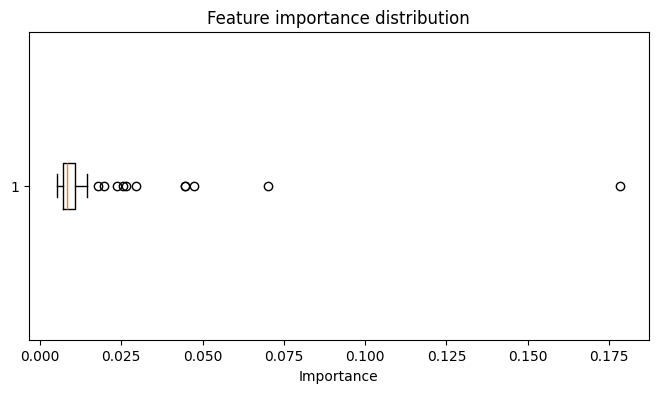

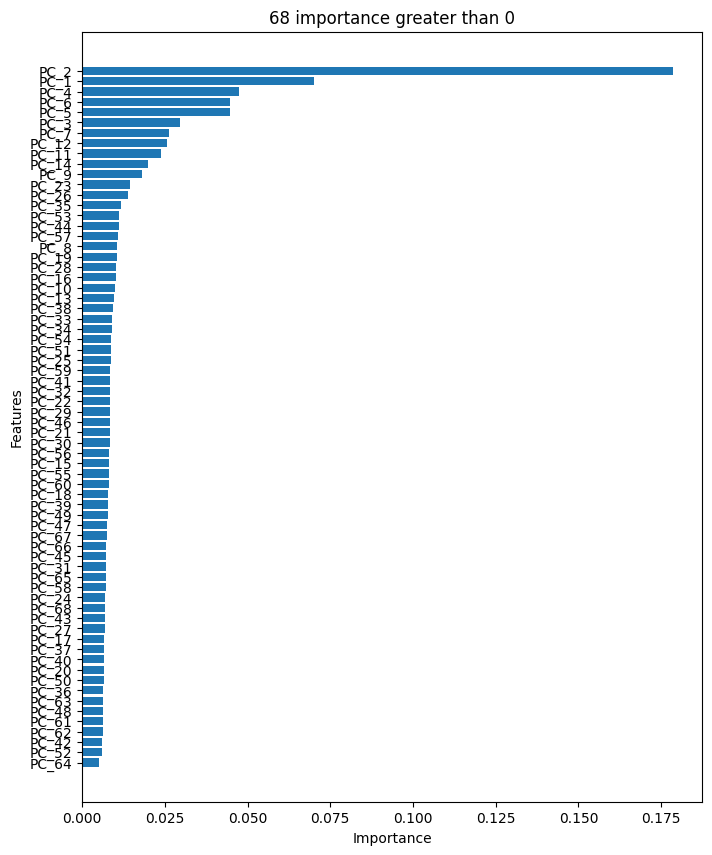

In [161]:
df_feat_importance_xgb_clf, df_feat_importance_non_zero_xgb_clf = calculate_feature_importance(xgb_clf)

### Cross-validation scores

>>>>>>>>> CV accuracy train mean: 0.9815
>>>>>>>>> CV accuracy test mean:  0.9776
>>>>>>>>> CV f1_macro train mean: 0.9815
>>>>>>>>> CV f1_macro test mean:  0.9776
>>>>>>>>> CV roc_auc train mean: 0.9973
>>>>>>>>> CV roc_auc test mean:  0.9957
>>>>>>>>> CV precision_macro train mean: 0.9816
>>>>>>>>> CV precision_macro test mean:  0.9778


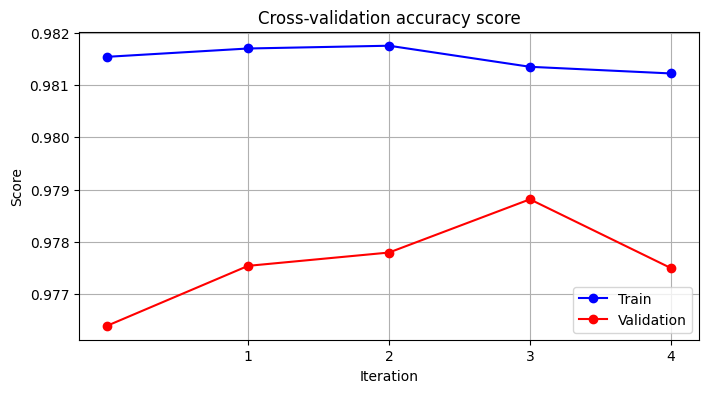

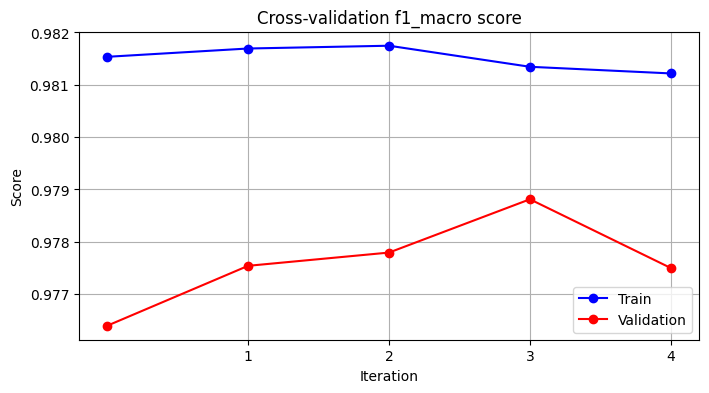

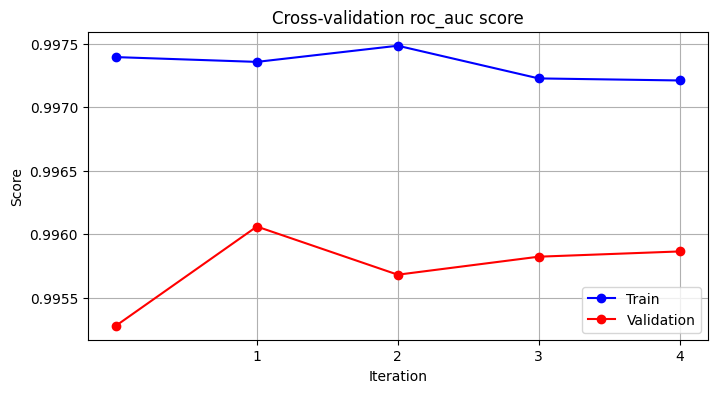

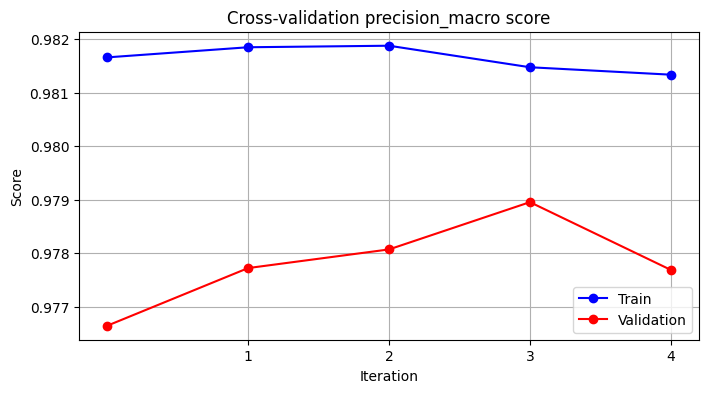

In [65]:
cv_results_xgb_clf = cross_validate(estimator=xgb_clf,
                                    X=X_train_reduced_new,
                                    y=y_train_balanced,
                                    scoring=parameters_xgb_clf.get('cross_validation')['scores'],
                                    cv=parameters_xgb_clf.get('cross_validation')['folders'],
                                    verbose=0,
                                    return_train_score=True,
                                    error_score=np.nan
                                    )

# Calculate cross-validation scores
for score in parameters_xgb_clf.get('cross_validation')['scores']:
    cv_train_mean = cv_results_xgb_clf[f'train_{score}'].mean().round(4)
    cv_test_mean  = cv_results_xgb_clf[f'test_{score}'].mean().round(4)
    plot_cross_validation_score(cv_results_xgb_clf, score)
    print(f'>>>>>>>>> CV {score} train mean: {cv_train_mean}')
    print(f'>>>>>>>>> CV {score} test mean:  {cv_test_mean}')

# Test

In [146]:
df_test = pd.read_csv('data\\original\\air_system_present_year.csv',
                      encoding='utf-8',
                      na_values=['na']
                      )

# Change class to int dummies
map_class = {'neg': 0, 'pos': 1}
df_test['class'] = df_test['class'].map(map_class)

# Columns all NaN dropes from train
cols_all_nan = df_test.columns.difference(df_train_no_outliers.columns).to_list()
# Columns with zero variance from train
cols_zero_variance = [col_to_drop]

# Concat columns and drop
cols_to_drop_from_train = cols_all_nan + cols_zero_variance
df_test.drop(columns=cols_to_drop_from_train, inplace=True)

# Features to float
features = df_test.drop(columns='class').columns
df_test[features] = df_test[features].astype(float)

In [147]:
# Calculate events proportion
total     = df_test.shape[0]
non_event = df_test[df_test['class'] == 0].shape[0]
event     = df_test[df_test['class'] == 1].shape[0]

non_event_percent = round(non_event / total * 100, 2)
event_percent     = round(event / total * 100, 2)

non_event_percent, event_percent

(97.66, 2.34)

## Input data on NaN

In [148]:
df_test[features] = imputer.transform(df_test[features])
df_test[features].isna().sum().sum()

np.int64(0)

In [151]:
X_test = df_test[features]
y_test = df_test['class']

## Scale data

In [152]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)
X_test_scaled.head()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,-0.844839,-0.237020,-0.166944,-0.216601,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.299235,...,-0.850979,-0.876809,-0.858456,-0.823842,-0.676518,-0.600101,-0.601703,-0.347014,-0.061429,-0.072045
1,-0.844446,-0.237020,-0.159145,-0.205962,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,-0.851042,-0.876186,-0.855939,-0.825129,-0.676497,-0.599461,-0.601703,-0.347014,-0.061429,-0.072045
2,0.330934,2.976011,-0.135748,-0.178605,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,0.760627,...,0.179506,0.840997,0.057783,-0.180364,2.683116,-0.337470,-0.598138,-0.347014,-0.061429,-0.072045
3,0.220635,-0.237020,-0.006093,0.134483,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,0.274933,0.221614,0.147732,0.335985,0.425433,-0.241041,1.344214,-0.054429,-0.061429,-0.072045
4,-0.813564,-0.237020,-0.144847,-0.167966,-0.077082,-0.076443,-0.132911,-0.305014,-0.294271,-0.313679,...,-0.837319,-0.858711,-0.820837,-0.706279,-0.668603,-0.599427,-0.601178,-0.347014,-0.061429,-0.072045


## PCA

In [155]:
cols_test_pca = ['PC_' + str(i +1) for i in range(n_components_expl_var)]
X_test_pca = pca_new.transform(X_test_scaled)
X_test_pca = pd.DataFrame(X_test_pca, columns=cols_test_pca)
X_test_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_59,PC_60,PC_61,PC_62,PC_63,PC_64,PC_65,PC_66,PC_67,PC_68
0,-6.839888,-1.204088,0.545117,-1.196652,-0.350128,-0.987213,-0.435019,0.238318,0.103291,0.125855,...,0.268503,-0.210033,0.096088,-0.228797,-0.082855,-0.188525,0.211871,-0.214801,0.217035,0.151770
1,-7.031989,-1.232820,0.536936,-1.388248,-0.224036,-1.240416,-0.602650,0.180844,0.068712,0.271149,...,0.078842,-0.103550,0.057200,0.029498,-0.036676,-0.095718,0.084535,-0.245241,-0.071314,0.157608
2,5.277963,2.839042,7.054011,-5.136034,1.069959,6.356968,3.077777,-2.872570,0.689751,-1.110134,...,-3.862481,4.874412,3.924409,-0.669361,-0.945089,-1.300049,-2.374391,-1.886488,1.075919,-0.512287
3,1.726622,-2.802912,0.329231,3.458827,-0.524483,1.039195,-0.156333,-1.287389,-0.051075,-0.302672,...,0.107298,-0.492480,-0.646398,-0.474363,-0.177789,-0.160140,-0.238628,0.939830,0.000044,-0.286911
4,-6.900671,-1.258392,0.528504,-1.312763,-0.201468,-1.126786,-0.493519,0.146564,0.074033,0.277205,...,0.049997,-0.166707,0.066257,0.159163,-0.077235,-0.061257,0.062840,-0.336518,-0.114938,0.192437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,4278.856884,12924.294606,4461.888014,5244.002919,-12061.161968,7576.406396,31533.566340,20592.645364,29803.475795,-12596.738055,...,24778.726623,8709.542687,35129.065907,1672.803788,15794.426185,-45684.826250,-15869.893758,19249.015670,-28960.399688,43996.663428
15996,-7.105506,-1.244529,0.622508,-1.597827,-0.100630,-1.091959,-0.407140,0.096922,0.024276,0.373470,...,0.035909,-0.062914,0.069158,0.130342,0.036856,-0.143432,0.064914,-0.257993,-0.215702,0.116534
15997,5.917689,-2.941571,0.278579,6.907413,-0.459519,3.408058,2.037963,-2.273054,-0.674533,1.779565,...,0.820829,0.892512,3.331259,-3.041884,2.007308,-1.343373,-0.213986,-0.440989,-0.438397,-1.714685
15998,-6.955678,-1.248035,0.507997,-1.342204,-0.260160,-1.099406,-0.523170,0.209300,0.087631,0.210179,...,0.155660,-0.147284,0.072979,0.006617,-0.043153,-0.102402,0.056050,-0.248738,0.042347,0.153863


# Predict

In [156]:
# Predict event probabilities
y_predict_proba = xgb_clf.predict_proba(X_test_pca)[:, 1]
y_predict_proba

array([0.02552774, 0.00254156, 0.2421023 , ..., 0.02043942, 0.0048598 ,
       0.00350853], dtype=float32)

# Metrics

In [157]:
costs = {"maintenance_cost": {"no_defect_cost" : 10,
                              "preventive_cost": 25,
                              "corrective_cost": 500}
        }
no_defect_cost  = costs.get('maintenance_cost')['no_defect_cost']
preventive_cost = costs.get('maintenance_cost')['preventive_cost']
corrective_cost = costs.get('maintenance_cost')['corrective_cost']

In [158]:
results = []
for cutoff in np.arange(0.05, 0.99, 0.05):
    y_predict      = np.where(y_predict_proba >= cutoff, 1, 0)
    accuracy       = accuracy_score(y_test, y_predict)
    precision      = precision_score(y_test, y_predict, zero_division=0)
    recall         = recall_score(y_test, y_predict, zero_division=0)
    f1score        = f1_score(y_test, y_predict, zero_division=0)
    auc_value      = roc_auc_score(y_test, y_predict)
    tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
    specificity    = tn / (tn + fp)
    no_defect_maintenance_cost  = fp * no_defect_cost
    # preventive_maintenance_cost = tp * preventive_cost
    corrective_maintenance_cost = fn * corrective_cost
    total_maintenance_cost = no_defect_maintenance_cost + corrective_maintenance_cost
                                # + preventive_maintenance_cost \
                              
    results.append([cutoff, accuracy, precision,
                    recall, f1score,
                    auc_value, tn, fp, fn, tp,
                    specificity, no_defect_maintenance_cost,
                    # preventive_maintenance_cost,
                    corrective_maintenance_cost,
                    total_maintenance_cost]
                  )

In [159]:
df_metrics = pd.DataFrame(results,
                          columns=['cutoff', 'accuracy', 'precision',
                                   'recall', 'f1score' , 'auc_value',
                                   'tn', 'fp', 'fn', 'tp',
                                   'specificity', 'no_defect_maintenance_cost',
                                #    'preventive_maintenance_cost',
                                   'corrective_maintenance_cost',
                                   'total_maintenance_cost']
                         )
df_metrics

,cutoff,accuracy,precision,recall,f1score,auc_value,tn,fp,fn,tp,specificity,no_defect_maintenance_cost,corrective_maintenance_cost,total_maintenance_cost
0,0.05,0.657125,0.055951,0.858667,0.105057,0.755477,10192,5433,53,322,0.652288,54330,26500,80830
1,0.10,0.721250,0.056075,0.688000,0.103698,0.705024,11282,4343,117,258,0.722048,43430,58500,101930
2,0.15,0.749938,0.049005,0.525333,0.089647,0.640331,11802,3823,178,197,0.755328,38230,89000,127230
3,0.20,0.769250,0.042483,0.410667,0.077000,0.594261,12154,3471,221,154,0.777856,34710,110500,145210
4,0.25,0.781438,0.035417,0.317333,0.063722,0.554955,12384,3241,256,119,0.792576,32410,128000,160410
5,0.30,0.789500,0.029550,0.250667,0.052868,0.526549,12538,3087,281,94,0.802432,30870,140500,171370
6,0.35,0.795312,0.023966,0.194667,0.042678,0.502197,12652,2973,302,73,0.809728,29730,151000,180730
7,0.40,0.798937,0.018305,0.144000,0.032481,0.479328,12729,2896,321,54,0.814656,28960,160500,189460
8,0.45,0.802125,0.013254,0.101333,0.023442,0.460139,12796,2829,337,38,0.818944,28290,168500,196790
9,0.50,0.804625,0.010672,0.080000,0.018832,0.451008,12844,2781,345,30,0.822016,27810,172500,200310


In [ ]:
df_metrics['total_maintenance_cost'].min()

In [ ]:
fig = px.bar(df_metrics, x='cutoff', y='corrective_maintenance_cost',)
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                #   legend=dict(yanchor="top", y=1.06, xanchor="left", x=0, orientation="h"),
                #   yaxis = dict(title="Condutividade"),
                #   xaxis = dict(title="Index")
                  )
fig.show()

In [ ]:
fig = px.bar(df_metrics, x='cutoff', y='no_defect_maintenance_cost',)
fig.update_layout(height=400,
                  width=800,
                  showlegend=True,
                  margin=dict(l=10, r=10, b=10, t=10),
                #   legend=dict(yanchor="top", y=1.06, xanchor="left", x=0, orientation="h"),
                #   yaxis = dict(title="Condutividade"),
                #   xaxis = dict(title="Index")
                  )
fig.show()

In [ ]:
fig = px.parallel_coordinates(df_metrics,
                              color='total_maintenance_cost',
                              labels=['cutoff',
                                #       'auc_value',
                                #       'recall',
                                #       'precision',
                                      'no_defect_maintenance_cost',
                                      # 'preventive_maintenance_cost',
                                      'corrective_maintenance_cost',
                                      'total_maintenance_cost']
                              )
fig.show()